In [1]:
import pandas as pd

import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.cluster import DBSCAN

from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import adjusted_rand_score, confusion_matrix

In [2]:
X_unsup = pd.read_csv(r"C:\Users\kassi\Desktop\ProjectUNSW\Training and Testing Sets\UNSW_NB15_training-set.csv")

print(X_unsup.head())

   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  attack_cat  \
0                 0   

In [3]:
X_unsup.isnull().sum() # To see missing values

X_unsup = X_unsup.dropna() # Drop any rows with missing data

# Save true labels before removing from the main dataset

labels_true = X_unsup['label']

In [4]:
#drop label

X_unsup = X_unsup.drop(columns=["label"],axis=1)
X_unsup = pd.get_dummies(X_unsup, columns=["proto", "state"])
X_unsup.head()


,id,dur,service,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,...,proto_zero,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,1,0.121478,-,6,4,258,172,74.087490,252,254,...,False,False,False,True,False,False,False,False,False,False
1,2,0.649902,-,14,38,734,42014,78.473372,62,252,...,False,False,False,True,False,False,False,False,False,False
2,3,1.623129,-,8,16,364,13186,14.170161,62,252,...,False,False,False,True,False,False,False,False,False,False
3,4,1.681642,ftp,12,12,628,770,13.677108,62,252,...,False,False,False,True,False,False,False,False,False,False
4,5,0.449454,-,10,6,534,268,33.373826,254,252,...,False,False,False,True,False,False,False,False,False,False


In [5]:
# Replace any string placeholder values like '-' with NaN

X_unsup.replace('-', np.nan, inplace=True)

# Convert all data to numeric (coerce non-convertible entries to NaN)

X_unsup = X_unsup.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with the column means

X_unsup.fillna(X_unsup.mean(numeric_only=True), inplace=True)


In [6]:

# Check again — this should now be empty if all NaNs are handled

print("Remaining NaNs:", X_unsup.isnull().sum().sum())

# Drop any remaining columns with NaN values

X_unsup.dropna(axis=1, inplace=True)

Remaining NaNs: 350682


In [7]:
#scaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_unsup)

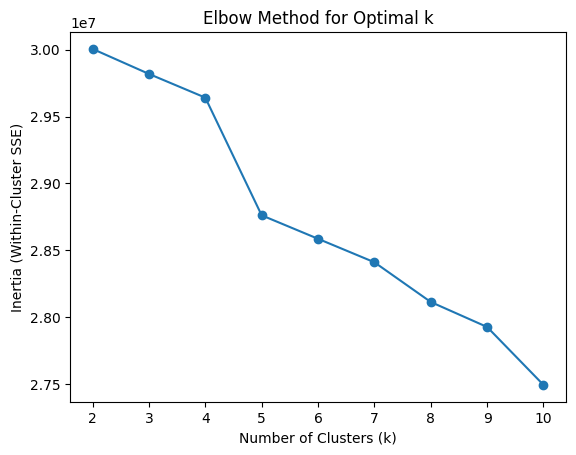

In [8]:

# Try different numbers of clusters

inertia = []

cluster_range = range(2, 11)


for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow method graph

plt.plot(cluster_range, inertia, marker='o')

plt.xlabel('Number of Clusters (k)')

plt.ylabel('Inertia (Within-Cluster SSE)')

plt.title('Elbow Method for Optimal k')

plt.show()



In [9]:
kmeans = KMeans(n_clusters=4, random_state=42) # Replace k 

cluster_labels = kmeans.fit_predict(X_scaled)

In [10]:
from sklearn.metrics import adjusted_rand_score

best_ari = -1
best_eps = 0
best_min_samples = 0

for eps in [1.5, 2.0, 2.2, 2.5, 3.0]:
    for min_samples in [3, 5, 7]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X_scaled)

        # Filter out noise points (-1) for fair evaluation
        valid = cluster_labels != -1
        if valid.sum() == 0: continue  # Skip if all are noise

        ari = adjusted_rand_score(labels_true[valid], cluster_labels[valid])

        print(f"eps={eps}, min_samples={min_samples}, ARI={ari:.4f}")
        if ari > best_ari:
            best_ari = ari
            best_eps = eps
            best_min_samples = min_samples

print(f"\nBest DBSCAN Settings → eps={best_eps}, min_samples={best_min_samples}, ARI={best_ari:.4f}")


eps=1.5, min_samples=3, ARI=0.1433
eps=1.5, min_samples=5, ARI=0.1453
eps=1.5, min_samples=7, ARI=0.1466
eps=2.0, min_samples=3, ARI=0.1836
eps=2.0, min_samples=5, ARI=0.1847
eps=2.0, min_samples=7, ARI=0.1855
eps=2.2, min_samples=3, ARI=0.1837
eps=2.2, min_samples=5, ARI=0.1845
eps=2.2, min_samples=7, ARI=0.1852
eps=2.5, min_samples=3, ARI=0.0747
eps=2.5, min_samples=5, ARI=0.0751
eps=2.5, min_samples=7, ARI=0.0754
eps=3.0, min_samples=3, ARI=0.0737
eps=3.0, min_samples=5, ARI=0.0739
eps=3.0, min_samples=7, ARI=0.0741

Best DBSCAN Settings → eps=2.0, min_samples=7, ARI=0.1855


In [11]:
# Best parameters found from grid
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
cluster_labels = dbscan.fit_predict(X_scaled)

# Evaluate only on non-noise points
valid = cluster_labels != -1
labels_true_valid = labels_true[valid]
cluster_labels_valid = cluster_labels[valid]

from sklearn.metrics import confusion_matrix

print("Adjusted Rand Index:", adjusted_rand_score(labels_true_valid, cluster_labels_valid))
print("Confusion Matrix:\n", confusion_matrix(labels_true_valid, cluster_labels_valid))


Adjusted Rand Index: 0.18546133559486883
Confusion Matrix:
 [[ 8077    77    15 ...     0     0     0]
 [36711  1491     0 ...    21    24    42]
 [    0     0     0 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]


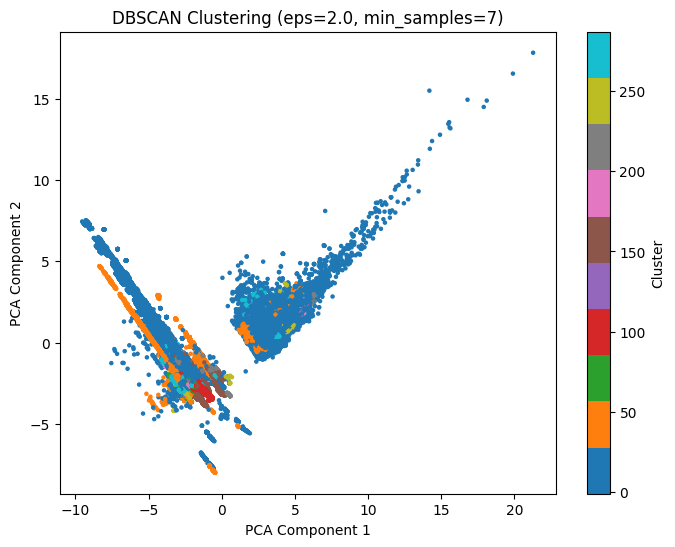

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', s=5)
plt.title(f"DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster')
plt.show()
